In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
#from datetime import datetime, timedelta
import backtrader as bt
import quantstats
from collections import defaultdict
#Import my function library
import ipynb.fs.full.MRT_Funcs as MRT

//anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
class BOLLStrat(bt.Strategy):
 
    '''
    This is a simple mean reversion bollinger band strategy.
 
    Entry Critria:
        - Long:
            - Price closes below the lower band
            - Stop Order entry when price crosses back above the lower band
        - Short:
            - Price closes above the upper band
            - Stop order entry when price crosses back below the upper band
    Exit Critria
        - Long/Short: Price touching the median line
    '''
 
    params = (
        ("period", 20),
        ("devfactor", 2),
        ("size", 20),
        ("debug", False)
        )
 
    def __init__(self):
        self.boll = bt.indicators.BollingerBands(period=self.p.period, devfactor=self.p.devfactor)
        #self.sx = bt.indicators.CrossDown(self.data.close, self.boll.lines.top)
        #self.lx = bt.indicators.CrossUp(self.data.close, self.boll.lines.bot)
 
    def notify_trade(self,trade):
        if trade.isclosed:
            dt = self.data.datetime.date()
 
            print('---------------------------- TRADE ---------------------------------')
            print("1: Data Name:                            {}".format(trade.data._name))
            print("2: Current date:                         {}".format(dt))
            print('3: Status:                               Trade Complete')
            print('4: PnL:                                  {}'.format(round(trade.pnl,2)))
            print('--------------------------------------------------------------------')
            
    def next(self):
 
        orders = self.broker.get_orders_open()
 
        # Cancel open orders so we can track the median line
        if orders:
            for order in orders:
                self.broker.cancel(order)
 
        if not self.position:
 
            if self.data.close > self.boll.lines.top:
 
                self.sell(exectype=bt.Order.Stop, price=self.boll.lines.top[0], size=self.p.size)
 
            if self.data.close < self.boll.lines.bot:
                self.buy(exectype=bt.Order.Stop, price=self.boll.lines.bot[0], size=self.p.size)
 
 
        else:
 
 
            if self.position.size > 0:
                self.sell(exectype=bt.Order.Limit, price=self.boll.lines.mid[0], size=self.p.size)
 
            else:
                self.buy(exectype=bt.Order.Limit, price=self.boll.lines.mid[0], size=self.p.size)
 
        if self.p.debug:
            print('---------------------------- NEXT ----------------------------------')
            print("1: Data Name:                            {}".format(data._name))
            print("2: Bar Num:                              {}".format(len(data)))
            print("3: Current date:                         {}".format(data.datetime.datetime()))
            print('4: Open:                                 {}'.format(data.open[0]))
            print('5: High:                                 {}'.format(data.high[0]))
            print('6: Low:                                  {}'.format(data.low[0]))
            print('7: Close:                                {}'.format(data.close[0]))
            print('8: Volume:                               {}'.format(data.volume[0]))
            print('9: Position Size:                       {}'.format(self.position.size))
            print('--------------------------------------------------------------------')

In [24]:
class SMA_dual(bt.Strategy): 
    # Strategy parameters
    params = (('wshort',15),('wlong',45),('shortlongthresh',0.05),('wext',30),('extthresh',0.25))

    def __init__(self):
         
        #I think I need to change datas[0] to get all the data streams (ie multiple tickers)
        self.dataclose = self.datas[0].close
        
        #print(self.datas[0]) #datas[i] contains the data for the ith ticker
        
        # Order variable will contain ongoing order details/status
        self.order = None

        #Get indicators
        self.short_sma = bt.indicators.MovingAverageSimple(self.datas[0], 
                        period=self.params.wshort, plotname='Short SMA')
        self.long_sma = bt.indicators.MovingAverageSimple(self.datas[0], 
                        period=self.params.wlong, plotname='Long SMA')
        self.ext_sma = bt.indicators.MovingAverageSimple(self.datas[0], 
                        period=self.params.wext, plotname='Extension SMA')
        self.sma200 = bt.indicators.MovingAverageSimple(self.datas[0], 
                        period=200, plotname='200-day SMA')
        #self.std = bt.indicators.StandardDeviation(self.data, period = self.params.wext)
        
        #Calculate signals
        self.extension = (self.dataclose - self.ext_sma)/ self.ext_sma
        self.shortlongratio = self.short_sma/self.long_sma
            
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} {txt}') # Comment this line when running optimization
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # An active Buy/Sell order has been submitted/accepted - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                #self.log(f'BUY EXECUTED, {order.executed.price:.2f}, {order.data._name}')
                self.log(f'BUY EXECUTED, {order.executed.price:.2f}')
            elif order.issell():
                self.log(f'SELL EXECUTED, {order.executed.price:.2f}')
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Reset orders
        self.order = None
            
    def next(self):
        # Check for open orders
        if self.order:
            return

        # Check if we are in the market
        if self.position.size == 0:
            # We are not in the market, look for a signal to BUY
            #if self.dataclose > self.sma200: #Only buy if the price is above the 200-day SMA
            if self.extension < -self.params.extthresh and self.shortlongratio < 1-self.params.shortlongthresh:
                self.log(f'BUY CREATE {self.dataclose[0]:2f}')
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()
        elif self.position.size > 0:
            # We are in the market, look for a signal to SELL
            if self.extension > -self.params.extthresh or self.shortlongratio > 1:
                self.log(f'SELL CREATE {self.dataclose[0]:2f}')
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
            
                
            #Not sure where to put the CLOSE CREATE to ensure we close any positions at the end of a backtest
        #else:
            # We are already in the market, look for a signal to CLOSE trades
            #if len(self) >= (self.bar_executed + 5):
                #self.log(f'CLOSE CREATE {self.dataclose[0]:2f}')
                #self.order = self.close()

In [32]:
class SMAportfolio(bt.Strategy):

    # Strategy parameters
    params = (('wshort',15),('wlong',45),('shortlongthresh',0.05),('wext',30),('extthresh',0.25))

    def __init__(self):
        #Initialize signal storage
        self.shortlongratios = []
        self.extensions = []
         
        #For each ticker
        for d in self.datas: 
            #Calculate indicatora for ticker d
            short_sma = bt.ind.SMA(d, period=self.params.wshort)
            long_sma = bt.ind.SMA(d, period=self.params.wlong)
            ext_sma = bt.ind.SMA(d, period=self.params.wext)
            
            #Calculate signals for ticker d
            shortlongratio = short_sma/long_sma
            extension = (d.close - ext_sma)/ext_sma
            
            #Append signals for ticker d to storage
            self.shortlongratios.append(shortlongratio)
            self.extensions.append(extension)
 
    def next(self):
        #For each ticker
        for i, d in enumerate(self.datas):
            #if position is zero (we don't hold ticker d)
            if not self.getposition(d).size:
                #If crossover signal is positive
                if self.extensions[i] < 0:
                    #Buy ticker d
                    self.buy(data = d)
            #only reached if position is not zero (we hold ticker d):
                #if crossover signal is negative
            elif self.extensions[i] > 0: 
                #Sell ticker d
                self.close(data = d)

In [29]:
class MaCrossStrategy(bt.Strategy):

    params = (('fast_length', 5),('slow_length', 25))
     
    def __init__(self):
        #Initialize signal storage
        self.crossovers = []
         
        #For each ticker
        for d in self.datas: 
            #Calculate indicators for ticker d
            ma_fast = bt.ind.SMA(d, period = self.params.fast_length)
            ma_slow = bt.ind.SMA(d, period = self.params.slow_length)
            
            #Calculate signals for ticker d
            crossover = bt.ind.CrossOver(ma_fast, ma_slow)
            
            #Append signals for ticker d to storage
            self.crossovers.append(crossover)
 
    def next(self):
        #For each ticker
        for i, d in enumerate(self.datas):
            #if position is zero (we don't hold ticker d)
            if not self.getposition(d).size:
                #If crossover signal is positive
                if self.crossovers[i] > 0:
                    #Buy ticker d
                    self.buy(data = d)
            #only reached if position is not zero (we hold ticker d):
                #if crossover signal is negative
            elif self.crossovers[i] < 0: 
                #Sell ticker d
                self.close(data = d)

In [35]:
import backtrader as bt
import matplotlib
from datetime import datetime

start_date = '2018-01-01'
end_date = '2019-01-01'

cerebro = bt.Cerebro()

tickers = ['BTC-CAD','ETH-CAD','ADA-CAD']

#Add data feed to Cerebro
MRT.addPortfolioToFeed(tickers, cerebro, start_date, end_date) 
 
#cerebro.addstrategy(MaCrossStrategy)
cerebro.addstrategy(SMAportfolio)

cerebro.broker.setcash(100.0)
 
cerebro.addsizer(bt.sizers.PercentSizer, percents = 10)

#Set broker commission rate
cerebro.broker.setcommission(commission=0.01)  # 1% of the operation value
 
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = "sharpe")
cerebro.addanalyzer(bt.analyzers.Returns,     _name = "returns")
cerebro.addanalyzer(bt.analyzers.Transactions, _name = "trans")

# Run Cerebro Engine
start_portfolio_value = cerebro.broker.getvalue()

results = cerebro.run()
strat = results[0]

end_portfolio_value = cerebro.broker.getvalue()
pnl = end_portfolio_value - start_portfolio_value
print(f'Starting Portfolio Value: {start_portfolio_value:2f}')
print(f'Final Portfolio Value: {end_portfolio_value:2f}')
print(f'PnL: {pnl:.2f}')

#back[0].analyzers.returns.get_analysis()['rnorm100']
#back[0].analyzers.sharpe.get_analysis()
#back[0].analyzers.trans.get_analysis()

cerebro.plot()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100.000000
Final Portfolio Value: 89.293407
PnL: -10.71


[[<Figure size 864x576 with 11 Axes>]]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
2018-11-20 BUY CREATE 5923.880859
2018-11-21 BUY EXECUTED, 5942.07
2018-11-21 SELL CREATE 6088.827637
2018-11-22 SELL EXECUTED, 6101.26
2018-11-22 BUY CREATE 5758.871582
2018-11-23 BUY EXECUTED, 5751.96
2018-11-28 SELL CREATE 5651.852539
2018-11-29 SELL EXECUTED, 5667.23
2018-11-30 BUY CREATE 5338.423340
2018-12-01 BUY EXECUTED, 5347.99
2018-12-01 SELL CREATE 5603.827637
2018-12-02 SELL EXECUTED, 5585.29
2018-12-06 BUY CREATE 4715.793945
2018-12-07 BUY EXECUTED, 4704.39
2018-12-09 SELL CREATE 4815.591309
2018-12-10 SELL EXECUTED, 4812.68
Starting Portfolio Value: 100.000000
Final Portfolio Value: 99.971447
PnL: -0.03


<IPython.core.display.Javascript object>


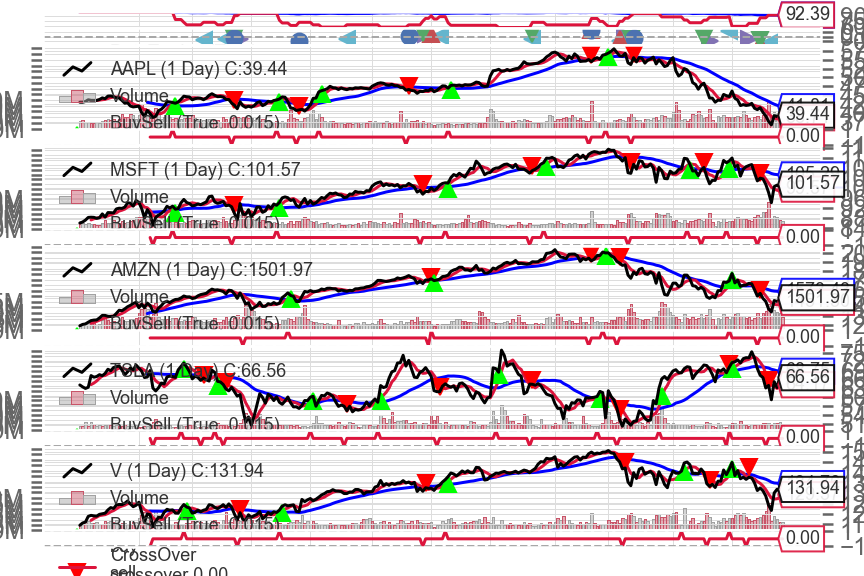

In [15]:
#Training set: cryptos valid back to 2018-01
#tickers = ['ADA-CAD','BAT-CAD','BCH-CAD','BTC-CAD','DOGE-CAD','ETH-CAD','FIL-CAD','LINK-CAD','LTC-CAD','MANA-CAD','MKR-CAD','XTZ-CAD','XLM-CAD','ZRX-CAD']
#Cryptos not in the training set
#tickers = ['AAVE-CAD','BAL-CAD','COMP-CAD','CRV-CAD','KNC-CAD','MATIC-CAD','SNX-CAD','SUSHI-CAD','UMA-CAD','UNI3-CAD','YFI-CAD']
#All cryptos:
#tickers = ['AAVE-CAD','BAL-CAD','BAT-CAD','BCH-CAD','BTC-CAD','COMP-CAD','CRV-CAD','DOGE-CAD','ETH-CAD','FIL-CAD','KNC-CAD','LINK-CAD','LTC-CAD','MANA-CAD','MATIC-CAD','MKR-CAD','SNX-CAD','SUSHI-CAD','UMA-CAD','UNI3-CAD','YFI-CAD','ZRX-CAD']
#Small dummy set:
tickers = ['BTC-CAD','ETH-CAD','ADA-CAD']
#tickers = ['AMZN','GOOGL','AAPL','SNP','TSLA','RACE']

start_date = '2018-01-01'
end_date = '2019-01-01'

tearsheet=False
plot=True

#Strategy parameters
wshort = 15
wlong = 45
shortlongthresh=0.05
wext=30
extthresh=0.25

#Instantiate Cerebro engine
cerebro = bt.Cerebro()

#Add data feed to Cerebro
MRT.addPortfolioToFeed(tickers, cerebro, start_date, end_date)
#data = bt.feeds.PandasData(dataname=yf.download(tickers[0], start_date, end_date))
#cerebro.adddata(data, name=tickers[0])

#Add strategy to Cerebro
cerebro.addstrategy(SMA_dual, wshort=wshort, wlong=wlong, shortlongthresh=shortlongthresh, wext=wext, extthresh=extthresh)
#cerebro.addstrategy(BOLLStrat)
#cerebro.addstrategy(TestStrategy2)

#Default position size
cerebro.addsizer(bt.sizers.PercentSizer, percents = 20)

#Set broker cash initial value
cerebro.broker.set_cash(100) 

#Set broker commission rate
cerebro.broker.setcommission(commission=0.01)  # 1% of the operation value

#Add analyzers
if tearsheet:
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

#cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = "sharpe")
#cerebro.addanalyzer(bt.analyzers.Returns,     _name = "returns")
#cerebro.addanalyzer(bt.analyzers.Transactions, _name = "trans")


if __name__ == '__main__':
    # Run Cerebro Engine
    start_portfolio_value = cerebro.broker.getvalue()

    results = cerebro.run()
    strat = results[0]

    end_portfolio_value = cerebro.broker.getvalue()
    pnl = end_portfolio_value - start_portfolio_value
    print(f'Starting Portfolio Value: {start_portfolio_value:2f}')
    print(f'Final Portfolio Value: {end_portfolio_value:2f}')
    print(f'PnL: {pnl:.2f}')
    
    #print(results[0].analyzers.returns.get_analysis()['rnorm100'])
    #results[0].analyzers.sharpe.get_analysis()
    #print(len(results[0].analyzers.trans.get_analysis()))
    
    if plot:
        cerebro.plot()
    
    if tearsheet:
        portfolio_stats = strat.analyzers.getbyname('PyFolio')
        returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
        returns.index = returns.index.tz_convert(None)
        quantstats.reports.html(returns, output='backtrader_tearsheets/stats.html', title='quantstats test')